# Example 1: Qiskit VQE calculation on water

In this example, we will demonstrate how to use qc2 in conjunction with Qiskit to perform a simple VQE calculation on water molecule.

### Import required packages

In [1]:
# ASE molecule object
from ase.build import molecule

# Qiskit-related packages
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator

# ignore package import warnings
import warnings
warnings.filterwarnings('ignore')

# qc2 packages
from qc2.ase import PySCF
from qc2.data import qc2Data

### Instantiate `qc2Data` class and run qc2-ASE calculator

In [2]:
# set Atoms object
mol = molecule('H2O')

# instantiate qc2Data class
qc2data = qc2Data(
    molecule=mol,
    filename='h2o.hdf5',
    schema='qcschema'
)

# specify the qchem calculator
qc2data.molecule.calc = PySCF(method='scf.RHF', basis='sto-3g')

# run calculation and save qchem data in the hdf5 file
qc2data.run()

* Reference energy (Hartree): -74.9644048239943
* Saving qchem data in h2o.hdf5



This will then generate a `h2o.hdf5` file containing all relevant qchem data according to the `QCSchema`. To check the its data structure, run the following command in your shell:

In [3]:
!h5dump -n h2o.hdf5

HDF5 "h2o.hdf5" {
FILE_CONTENTS {
 group      /
 group      /keywords
 group      /model
 group      /molecule
 group      /properties
 group      /provenance
 group      /wavefunction
 dataset    /wavefunction/localized_orbitals_a
 dataset    /wavefunction/localized_orbitals_b
 dataset    /wavefunction/scf_eigenvalues_a
 dataset    /wavefunction/scf_eigenvalues_b
 dataset    /wavefunction/scf_eri
 dataset    /wavefunction/scf_eri_mo_aa
 dataset    /wavefunction/scf_eri_mo_ab
 dataset    /wavefunction/scf_eri_mo_ba
 dataset    /wavefunction/scf_eri_mo_bb
 dataset    /wavefunction/scf_fock_a
 dataset    /wavefunction/scf_fock_mo_a
 dataset    /wavefunction/scf_fock_mo_b
 dataset    /wavefunction/scf_orbitals_a
 dataset    /wavefunction/scf_orbitals_b
 }
}


You could also use `!h5dump h2o.hdf5` to inspect the numrical data contained within each `group` and `dataset`.

### Building up the molecular qubit Hamiltonian

In [4]:
# define activate space
n_active_electrons = (2, 2)    # => (n_alpha, n_beta)
n_active_spatial_orbitals = 3  # => active orbitals comprise of only 2px, 2py and 2pz of oxigen

# define the type of fermionic-to-qubit transformation
mapper = JordanWignerMapper()

# set up qubit Hamiltonian and core energy based on given activate space
e_core, qubit_op = qc2data.get_qubit_hamiltonian(
    n_active_electrons,
    n_active_spatial_orbitals,
    mapper,
    format='qiskit'
)

print(f'* Core energy (Hartree): {e_core}')
print(f'* Molecular Hamiltonian in qubit representation: \n {qubit_op}')

* Core energy (Hartree): -68.82716186445695
* Molecular Hamiltonian in qubit representation: 
 SparsePauliOp(['IIIIII', 'IIIIIZ', 'IIIYZY', 'IIIXZX', 'IIIIZI', 'IIIZII', 'IIZIII', 'YZYIII', 'XZXIII', 'IZIIII', 'ZIIIII', 'IIIIZZ', 'IIIZIZ', 'IIZIIZ', 'YZYIIZ', 'XZXIIZ', 'IZIIIZ', 'ZIIIIZ', 'IIIYIY', 'IIIXIX', 'IYYIYY', 'IXXIYY', 'IYYIXX', 'IXXIXX', 'YYIIYY', 'XXIIYY', 'YYIIXX', 'XXIIXX', 'IIZYZY', 'IIZXZX', 'YZYYZY', 'XZXYZY', 'YZYXZX', 'XZXXZX', 'IZIYZY', 'IZIXZX', 'ZIIYZY', 'ZIIXZX', 'IIIZZI', 'IIZIZI', 'YZYIZI', 'XZXIZI', 'IZIIZI', 'ZIIIZI', 'IYYYYI', 'IXXYYI', 'IYYXXI', 'IXXXXI', 'YYIYYI', 'XXIYYI', 'YYIXXI', 'XXIXXI', 'IIZZII', 'YZYZII', 'XZXZII', 'IZIZII', 'ZIIZII', 'IZZIII', 'ZIZIII', 'YIYIII', 'XIXIII', 'ZZIIII'],
              coeffs=[-4.51953960e+00+0.j,  5.12857178e-01+0.j,  7.92389604e-02+0.j,
  7.92389604e-02+0.j,  4.79944858e-01+0.j,  9.46688337e-02+0.j,
  5.12857178e-01+0.j,  7.92389604e-02+0.j,  7.92389604e-02+0.j,
  4.79944858e-01+0.j,  9.46688337e-02+0.j,  1.67646941e-

### Set up reference state and ansatz

* Reference state:


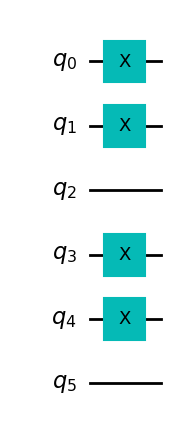

* Ansatz:


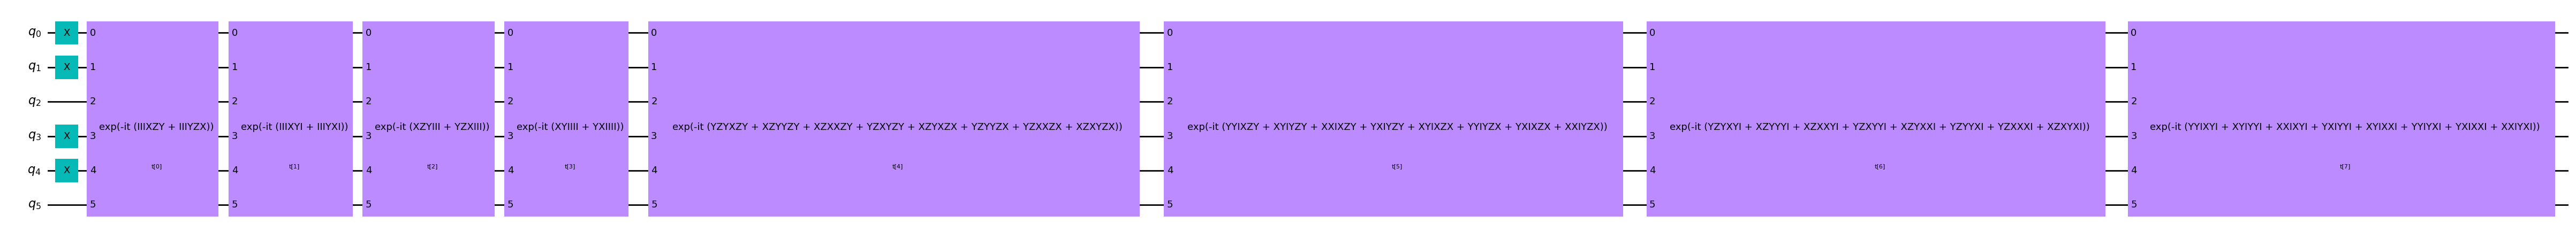

In [5]:
# build up the initial quantum circuit
reference_state = HartreeFock(
    n_active_spatial_orbitals,
    n_active_electrons,
    mapper,
)

print(f'* Reference state:')
display(reference_state.draw('mpl'))

# set up the ansatz using unitary CC as variational form
ansatz = UCCSD(
    n_active_spatial_orbitals,
    n_active_electrons,
    mapper,
    initial_state=reference_state
)

print(f'* Ansatz:')
# the option `fold=-1` forces the anzats to fit into the page
display(ansatz.decompose().draw('mpl', fold=-1))

### Run VQE

In [6]:
# set up qiskit_algorithms VQE object
# this uses qiskit Estimaror primitive, statevector simulator and SLSQP as optimizer
vqe_solver = VQE(Estimator(), ansatz, SLSQP())

# set initial circuit parameters as zero
vqe_solver.initial_point = [0.0] * ansatz.num_parameters

# run vqe
result = vqe_solver.compute_minimum_eigenvalue(qubit_op)

print("=== QISKIT VQE RESULTS ===")
print(f"* Electronic ground state energy (Hartree): {result.eigenvalue}")
print(f"* Inactive core energy (Hartree): {e_core}")
print(f">>> Total ground state energy (Hartree): {result.eigenvalue+e_core}\n")

=== QISKIT VQE RESULTS ===
* Electronic ground state energy (Hartree): -6.141912503035303
* Inactive core energy (Hartree): -68.82716186445695
>>> Total ground state energy (Hartree): -74.96907436749225



### Compare VQE result with classical qchem calculations

Now, let's compare our VQE enery with quantum chemistry calculations performed solely using PySCF. Here is a typical example run:

In [7]:
import pyscf
from pyscf import gto, scf, mcscf

# set up molecule
mol_h2o = gto.M(
    atom='O 0 0 0.1192622641;\
          H 0 0.763237638 -0.4770469398;\
          H 0 -0.763237638, -0.4770469398',
    basis='sto-3g'
)

# run HF
scf_h2o = scf.HF(mol_h2o)
hf_h2o = mol_h2o.HF().run()

# run CASCI and CASSCF single-point calculations
ncas, nelecas = (3, 4)
energy_casci = mcscf.CASCI(hf_h2o, ncas, nelecas).kernel()
energy_casscf = mcscf.CASSCF(hf_h2o, ncas, nelecas).kernel()

# run FCI single-point calculation
energy_fci = pyscf.fci.FCI(hf_h2o).kernel()

print('')
print(f'* Final CASCI/sto-3g energy (Hartree):  {energy_casci[0]}')
print(f'* Final CASSCF/sto-3g energy (Hartree): {energy_casscf[0]}')
print(f'* Final FCI/sto-3g energy (Hartree):    {energy_fci[0]}')

converged SCF energy = -74.9644047758074
CASCI E = -74.9690746787843  E(CI) = -6.14191473615338  S^2 = 0.0000000
CASSCF energy = -74.9766432970074
CASCI E = -74.9766432970074  E(CI) = -6.47224365957734  S^2 = 0.0000000

* Final CASCI/sto-3g energy (Hartree):  -74.96907467878432
* Final CASSCF/sto-3g energy (Hartree): -74.97664329700743
* Final FCI/sto-3g energy (Hartree):    -75.01542863912769


As expected, our final VQE energy from Qiskit agrees excelently well with the one obtained with PySCF at CASCI level.